## Imports

In [1]:
from google.colab import drive
from google.colab.files import download

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-1jay4izh
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-1jay4izh
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [3]:
!pip install ftfy regex tqdm

In [86]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
import csv
import random

In [6]:
import requests
import re
from collections import defaultdict

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

##  CLIP

In [12]:
# Step 1: Load the pre-trained CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [85]:
# Step 2: Analyze CLIP's architecture
print("Model Architecture:")
print(model)

Model Architecture:
CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, b

In [45]:
# Load Base CLIP Model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Analyse Visual Genome Dataset


In [87]:
# Replace these paths with the actual downloaded file paths
objects_file = '/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/objects.json'
relationships_file = '/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/relationships.json'
object_aliases_file = '/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/object_alias.txt'
relationship_aliases_file = '/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/relationship_alias.txt'

In [50]:
# Step 1: Load objects data
print("Loading Objects...")
with open(objects_file, "r") as f:
    objects_data = json.load(f)

print(f"Total images with objects: {len(objects_data)}")
print("Sample object annotation:")
print(objects_data[0])  # Display a sample

Loading Objects...
Total images with objects: 108077
Sample object annotation:
{'image_id': 1, 'objects': [{'synsets': ['tree.n.01'], 'h': 557, 'object_id': 1058549, 'merged_object_ids': [], 'names': ['trees'], 'w': 799, 'y': 0, 'x': 0}, {'synsets': ['sidewalk.n.01'], 'h': 290, 'object_id': 1058534, 'merged_object_ids': [5046], 'names': ['sidewalk'], 'w': 722, 'y': 308, 'x': 78}, {'synsets': ['building.n.01'], 'h': 538, 'object_id': 1058508, 'merged_object_ids': [], 'names': ['building'], 'w': 222, 'y': 0, 'x': 1}, {'synsets': ['street.n.01'], 'h': 258, 'object_id': 1058539, 'merged_object_ids': [3798578], 'names': ['street'], 'w': 359, 'y': 283, 'x': 439}, {'synsets': ['wall.n.01'], 'h': 535, 'object_id': 1058543, 'merged_object_ids': [], 'names': ['wall'], 'w': 135, 'y': 1, 'x': 0}, {'synsets': ['tree.n.01'], 'h': 360, 'object_id': 1058545, 'merged_object_ids': [], 'names': ['tree'], 'w': 476, 'y': 0, 'x': 178}, {'synsets': ['shade.n.01'], 'h': 189, 'object_id': 5045, 'merged_object_

In [51]:
# Step 2: Load relationships data
print("\nLoading Relationships...")
with open(relationships_file, "r") as f:
    relationships_data = json.load(f)

print(f"Total images with relationships: {len(relationships_data)}")
print("Sample relationship annotation:")
print(relationships_data[0])  # Display a sample


Loading Relationships...
Total images with relationships: 108077
Sample relationship annotation:
{'relationships': [{'predicate': 'ON', 'object': {'h': 290, 'object_id': 1058534, 'merged_object_ids': [5046], 'synsets': ['sidewalk.n.01'], 'w': 722, 'y': 308, 'x': 78, 'names': ['sidewalk']}, 'relationship_id': 15927, 'synsets': ['along.r.01'], 'subject': {'name': 'shade', 'h': 192, 'synsets': ['shade.n.01'], 'object_id': 5045, 'w': 274, 'y': 338, 'x': 119}}, {'predicate': 'wears', 'object': {'h': 28, 'object_id': 1058525, 'merged_object_ids': [5048], 'synsets': ['shoe.n.01'], 'w': 48, 'y': 485, 'x': 388, 'names': ['shoes']}, 'relationship_id': 15928, 'synsets': ['wear.v.01'], 'subject': {'name': 'man', 'h': 262, 'synsets': ['man.n.01'], 'object_id': 1058529, 'w': 60, 'y': 249, 'x': 238}}, {'predicate': 'has', 'object': {'name': 'headlight', 'h': 15, 'synsets': ['headlight.n.01'], 'object_id': 5050, 'w': 23, 'y': 366, 'x': 514}, 'relationship_id': 15929, 'synsets': ['have.v.01'], 'subjec

In [54]:
def download_and_parse_alias_files(url):
    """
    Downloads and parses a text file of relationships.
    The first word on each line is treated as the key, and the rest as aliases.
    Cleans extra spaces and ensures consistent formatting.
    """
    relationships = defaultdict(set)  # Using set to avoid duplicates

    # Step 1: Download the file
    print(f"Downloading relationship file from: {url}")
    response = requests.get(url)
    response.raise_for_status()  # Ensure the request was successful

    # Step 2: Parse and clean the content line by line
    for line in response.text.split("\n"):
        if line.strip():  # Skip empty lines
            # Clean each part of the line (remove extra spaces)
            parts = [re.sub(r'\s+', ' ', item.strip()) for item in line.split(",")]
            if len(parts) > 1:  # Key + aliases
                key = parts[0]  # First item is the key
                aliases = parts[1:]  # Remaining items are aliases
                relationships[key].update(aliases)  # Add aliases to the key's set

    # Convert sets to lists and sort aliases for easier handling
    relationships = {k: sorted(list(v)) for k, v in relationships.items()}
    return relationships

In [52]:
relationship_aliases_url = 'https://homes.cs.washington.edu/~ranjay/visualgenome/data/dataset/relationship_alias.txt'
object_aliases_url = 'https://homes.cs.washington.edu/~ranjay/visualgenome/data/dataset/object_alias.txt'

In [55]:
# Step 3: Download and parse the aliases
relationship_aliases = download_and_parse_alias_files(relationship_aliases_url)
object_aliases = download_and_parse_alias_files(object_aliases_url)



In [95]:
# Print the first few entries
print("First Few Relationships:")
for i, (key, aliases) in enumerate(relationship_aliases.items()):
    print(f"{key} -> {aliases}")
    if i >= 4:  # Stop after printing 5 entries
        break

First Few Relationships:
near -> ['are near', 'are near a', 'are near an', 'are near the', 'around', 'beside', 'by', 'is near', 'near a', 'near an', 'near the', 'next to', 'on side of']
above -> ['above a', 'above an', 'above the', 'are above', 'are above a', 'is above', 'on top of']
on -> ['are on', 'are on a', 'are on an', 'are on the', 'is on', 'is on a', 'is on the', 'on a', 'on a a', 'on an', 'on are', 'on front of', 'on the']
hanging from -> ['are hanging from', 'are hanging from a', 'hanging from a', 'hanging from the', 'hanging on']
in -> ['are in', 'are in a', 'are in an', 'are in the', 'in a', 'in an', 'in the', 'inside', 'inside of', 'is in', 'is in a', 'is in the']


In [91]:
# Print the first few entries
print("First Few Relationships:")
for i, (key, aliases) in enumerate(object_aliases.items()):
    print(f"{key} -> {aliases}")
    if i >= 4:  # Stop after printing 5 entries
        break

First Few Relationships:
called a forest -> ['is called a forest']
saver -> ['savers']
bookend -> ['bookends']
yellow -> ['is yellow', 'yellows']
gladiola -> ['gladiolas']


In [96]:
# Pick a sample image (e.g., the first entry in objects_data)
sample_data = objects_data[0]
image_id = sample_data['image_id']
image_path = f'/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/images/{image_id}.jpg'
# Display the image and associated data
print(f"\nSample Image ID: {image_id}")



Sample Image ID: 1


In [93]:
# Display associated objects with aliases
print("\nObjects in the image:")
for obj in sample_data['objects']:
    obj_name = obj['names'][0]  # Take the first name as the object name
    normalized_name = object_aliases.get(obj_name, [obj_name])[0]  # Apply alias if available
    print(f"Original: {obj_name}, Normalized: {normalized_name}")



Objects in the image:
Original: trees, Normalized: trees
Original: sidewalk, Normalized: sidewalks
Original: building, Normalized: building is a
Original: street, Normalized: streets
Original: wall, Normalized: walls
Original: tree, Normalized: of a tree
Original: shade, Normalized: shades
Original: van, Normalized: vans
Original: tree trunk, Normalized: tree trunk
Original: clock, Normalized: clock is
Original: windows, Normalized: windows
Original: man, Normalized: is a man
Original: man, Normalized: is a man
Original: lamp post, Normalized: lamp post
Original: sign, Normalized: signs
Original: car, Normalized: car is
Original: back, Normalized: back of
Original: jacket, Normalized: jacket is
Original: car, Normalized: car is
Original: pants, Normalized: pants
Original: shirt, Normalized: shirts
Original: parking meter, Normalized: parking meter
Original: pants, Normalized: pants
Original: shirt, Normalized: shirts
Original: shoes, Normalized: shoes
Original: arm, Normalized: an arm

In [97]:
print("\nRelationships in the image:")

# Extract the relationships list for the selected image ID
sample_relationships_data = next(
    (item['relationships'] for item in relationships_data if item['image_id'] == image_id),
    []
)

if not sample_relationships_data:
    print(f"No relationships found for image ID {image_id}.")
else:
    # Loop through relationships and handle normalization
    for rel in sample_relationships_data[:5]:  # Display only the first 5 relationships
        # Access predicate and normalize (handling case sensitivity)
        predicate = rel.get('predicate', '').lower()  # Use an empty string if 'predicate' is missing
        normalized_predicate = relationship_aliases.get(predicate, [predicate])[0]  # Apply alias if available

        # Access subject and object dictionaries
        subject = rel.get('subject', {})
        object_ = rel.get('object', {})

        # Get subject and object names safely
        subject_name = subject.get('name', subject.get('names', ["Unknown"])[0])  # Use 'names' if 'name' is missing
        object_name = object_.get('name', object_.get('names', ["Unknown"])[0])  # Use 'names' if 'name' is missing

        # Normalize subject and object names
        normalized_subject = object_aliases.get(subject_name, [subject_name])[0]
        normalized_object = object_aliases.get(object_name, [object_name])[0]

        # Print the relationship
        print(f"Relationship: {normalized_predicate}")
        print(f"  Subject: {normalized_subject}")
        print(f"  Object: {normalized_object}")



Relationships in the image:
Relationship: are on
  Subject: shades
  Object: sidewalks
Relationship: wears a
  Subject: is a man
  Object: shoes
Relationship: has a
  Subject: car is
  Object: headlights
Relationship: are on
  Subject: signs
  Object: building is a
Relationship: are on
  Subject: tree trunk
  Object: sidewalks


In [98]:
print("Sample Relationship Aliases:")
for k, v in list(relationship_aliases.items())[:5]:
    print(f"{k}: {v}")

print("\nSample Object Aliases:")
for k, v in list(object_aliases.items())[:5]:
    print(f"{k}: {v}")


Sample Relationship Aliases:
near: ['are near', 'are near a', 'are near an', 'are near the', 'around', 'beside', 'by', 'is near', 'near a', 'near an', 'near the', 'next to', 'on side of']
above: ['above a', 'above an', 'above the', 'are above', 'are above a', 'is above', 'on top of']
on: ['are on', 'are on a', 'are on an', 'are on the', 'is on', 'is on a', 'is on the', 'on a', 'on a a', 'on an', 'on are', 'on front of', 'on the']
hanging from: ['are hanging from', 'are hanging from a', 'hanging from a', 'hanging from the', 'hanging on']
in: ['are in', 'are in a', 'are in an', 'are in the', 'in a', 'in an', 'in the', 'inside', 'inside of', 'is in', 'is in a', 'is in the']

Sample Object Aliases:
called a forest: ['is called a forest']
saver: ['savers']
bookend: ['bookends']
yellow: ['is yellow', 'yellows']
gladiola: ['gladiolas']


In [99]:
for rel in sample_relationships_data[:5]:
    print("Original Relationship:")
    print(json.dumps(rel, indent=2))
    print("Normalized Output:")
    predicate = rel['predicate'].lower()
    normalized_predicate = relationship_aliases.get(predicate, [predicate])[0]
    subject_name = rel['subject'].get('name', rel['subject'].get('names', ["Unknown"])[0])
    object_name = rel['object'].get('name', rel['object'].get('names', ["Unknown"])[0])
    normalized_subject = object_aliases.get(subject_name, [subject_name])[0]
    normalized_object = object_aliases.get(object_name, [object_name])[0]
    print(f"Relationship: {normalized_predicate}")
    print(f"  Subject: {normalized_subject}")
    print(f"  Object: {normalized_object}")


Original Relationship:
{
  "predicate": "ON",
  "object": {
    "h": 290,
    "object_id": 1058534,
    "merged_object_ids": [
      5046
    ],
    "synsets": [
      "sidewalk.n.01"
    ],
    "w": 722,
    "y": 308,
    "x": 78,
    "names": [
      "sidewalk"
    ]
  },
  "relationship_id": 15927,
  "synsets": [
    "along.r.01"
  ],
  "subject": {
    "name": "shade",
    "h": 192,
    "synsets": [
      "shade.n.01"
    ],
    "object_id": 5045,
    "w": 274,
    "y": 338,
    "x": 119
  }
}
Normalized Output:
Relationship: are on
  Subject: shades
  Object: sidewalks
Original Relationship:
{
  "predicate": "wears",
  "object": {
    "h": 28,
    "object_id": 1058525,
    "merged_object_ids": [
      5048
    ],
    "synsets": [
      "shoe.n.01"
    ],
    "w": 48,
    "y": 485,
    "x": 388,
    "names": [
      "shoes"
    ]
  },
  "relationship_id": 15928,
  "synsets": [
    "wear.v.01"
  ],
  "subject": {
    "name": "man",
    "h": 262,
    "synsets": [
      "man.n.01"
   

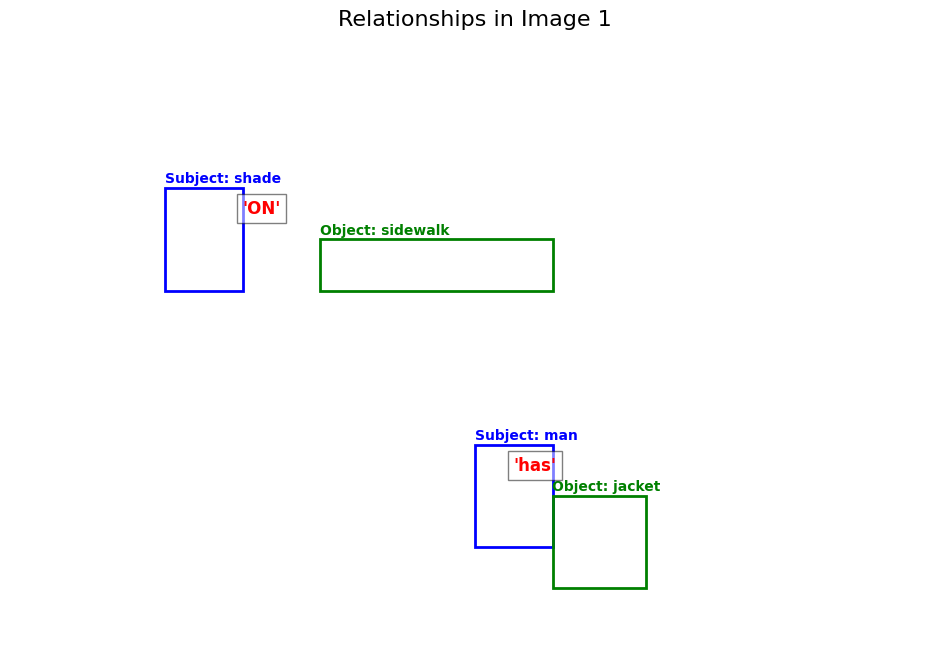

In [101]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Example setup
image_id = 1  # Replace with your image ID
relationships_data = [  # Replace with your loaded relationships data
    {
        "image_id": 1,
        "relationships": [
            {
                "predicate": "ON",
                "subject": {"name": "shade", "x": 100, "y": 150, "w": 50, "h": 100},
                "object": {"name": "sidewalk", "x": 200, "y": 200, "w": 150, "h": 50}
            },
            {
                "predicate": "has",
                "subject": {"name": "man", "x": 300, "y": 400, "w": 50, "h": 100},
                "object": {"name": "jacket", "x": 350, "y": 450, "w": 60, "h": 90}
            }
        ]
    }
]

# Canvas for visualization
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 600)  # Arbitrary canvas size
ax.set_ylim(0, 600)
ax.invert_yaxis()  # Match image coordinate system
ax.set_title(f"Relationships in Image {image_id}", fontsize=16)
ax.axis("off")

# Locate relationships for the image
relationships = [item["relationships"] for item in relationships_data if item["image_id"] == image_id][0]

# Visualize relationships
for rel in relationships:
    # Subject
    subject = rel["subject"]
    subject_x, subject_y, subject_w, subject_h = subject["x"], subject["y"], subject["w"], subject["h"]
    rect_subject = patches.Rectangle((subject_x, subject_y), subject_w, subject_h, linewidth=2, edgecolor="blue", facecolor="none")
    ax.add_patch(rect_subject)
    ax.text(subject_x, subject_y - 5, f"Subject: {subject['name']}", color="blue", fontsize=10, weight="bold")

    # Object
    object_ = rel["object"]
    object_x, object_y, object_w, object_h = object_["x"], object_["y"], object_["w"], object_["h"]
    rect_object = patches.Rectangle((object_x, object_y), object_w, object_h, linewidth=2, edgecolor="green", facecolor="none")
    ax.add_patch(rect_object)
    ax.text(object_x, object_y - 5, f"Object: {object_['name']}", color="green", fontsize=10, weight="bold")

    # Relationship
    predicate = rel["predicate"]
    mid_x = (subject_x + object_x) / 2
    mid_y = (subject_y + object_y) / 2
    ax.text(mid_x, mid_y, f"'{predicate}'", color="red", fontsize=12, weight="bold", bbox=dict(facecolor="white", alpha=0.5))

plt.show()

## Create VQA Dataset

In [ ]:
import csv

# Step 2.1: Function to Create VQA Pairs
def create_vqa_pairs(relationships_data, object_aliases, relationship_aliases, output_file, max_questions=50000):
    """
    Create VQA pairs from Visual Genome relationships data.

    Args:
        relationships_data: List of relationships from Visual Genome.
        object_aliases: Mapping for normalized object names.
        relationship_aliases: Mapping for normalized relationships.
        output_file: Path to save the generated VQA dataset.
        max_questions: Limit the number of generated questions.
    """
    vqa_data = []
    question_count = 0

    # Loop through relationships
    for image_entry in relationships_data:
        image_id = image_entry['image_id']
        relationships = image_entry.get('relationships', [])

        for rel in relationships:
            # Extract subject, object, and predicate
            predicate = rel.get('predicate', '').lower()
            subject = rel.get('subject', {}).get('name', 'unknown')
            object_name = rel.get('object', {}).get('name', 'unknown')

            # Normalize subject, object, and predicate
            normalized_subject = object_aliases.get(subject, [subject])[0]
            normalized_object = object_aliases.get(object_name, [object_name])[0]
            normalized_predicate = relationship_aliases.get(predicate, [predicate])[0]

            # Create a question and answer pair
            question = f"What is the relationship between {normalized_subject} and {normalized_object}?"
            answer = normalized_predicate
            image_path = f'/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/images/{image_id}.jpg'

            # Add to VQA data
            vqa_data.append({
                "image_id": image_id,
                "image_path": image_path,
                "question": question,
                "answer": answer
            })

            question_count += 1
            if question_count >= max_questions:
                break

        if question_count >= max_questions:
            break

    # Save VQA pairs to a CSV file
    print(f"Saving {len(vqa_data)} VQA pairs to {output_file}")
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['image_id', 'image_path', 'question', 'answer']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(vqa_data)



In [ ]:
# Step 2.2: Call the Function
output_vqa_file = '/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/vqa_dataset.csv'
create_vqa_pairs(
    relationships_data=relationships_data,
    object_aliases=object_aliases,
    relationship_aliases=relationship_aliases,
    output_file=output_vqa_file,
    max_questions=10000  # Limit the number of questions
)


Saving 10000 VQA pairs to /content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/vqa_dataset.csv


In [ ]:
vqa_df = pd.read_csv(output_vqa_file)
print("Sample VQA Data:")
print(vqa_df.head())

Sample VQA Data:
   image_id                                         image_path  \
0         1  /content/drive/MyDrive/Stat_Learning_Project/V...   
1         1  /content/drive/MyDrive/Stat_Learning_Project/V...   
2         1  /content/drive/MyDrive/Stat_Learning_Project/V...   
3         1  /content/drive/MyDrive/Stat_Learning_Project/V...   
4         1  /content/drive/MyDrive/Stat_Learning_Project/V...   

                                            question   answer  
0  What is the relationship between shades and un...   are on  
1  What is the relationship between is a man and ...  wears a  
2  What is the relationship between car is and he...    has a  
3  What is the relationship between signs and bui...   are on  
4  What is the relationship between tree trunk an...   are on  


In [15]:
# CLIP preprocessing for images
from transformers import CLIPProcessor

# Initialize the CLIP Processor
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def preprocess_image(image_path):
    """
    Preprocess an image using CLIP's visual requirements.
    """
    try:
        image = Image.open(image_path).convert("RGB")
        return clip_processor(images=image, return_tensors="pt").pixel_values
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

In [16]:
def tokenize_questions(questions):
    """
    Tokenize questions using CLIP's tokenizer.
    """
    return clip_processor.tokenizer(questions, return_tensors="pt", padding=True, truncation=True)["input_ids"]


In [17]:
def map_answers_to_indices(answers):
    """
    Map answers to indices for classification.
    """
    unique_answers = list(set(answers))  # Get unique answers
    answer_to_index = {ans: idx for idx, ans in enumerate(unique_answers)}
    index_to_answer = {idx: ans for ans, idx in answer_to_index.items()}
    return answer_to_index, index_to_answer


In [18]:
def map_answers_to_indices(answers):
    """
    Map answers to indices for classification.
    """
    unique_answers = list(set(answers))  # Get unique answers
    answer_to_index = {ans: idx for idx, ans in enumerate(unique_answers)}
    index_to_answer = {idx: ans for ans, idx in answer_to_index.items()}
    return answer_to_index, index_to_answer


In [ ]:
class CLIPVQADataset(torch.utils.data.Dataset):
    """
    Custom Dataset for VQA using CLIP.
    """
    def __init__(self, data, answer_to_index):
        self.data = data
        self.answer_to_index = answer_to_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Preprocess Image
        image = preprocess_image(sample['image_path'])

        # Tokenize Question
        question = clip_processor.tokenizer(sample['question'], return_tensors="pt", padding="max_length", truncation=True)["input_ids"]

        # Map Answer to Index
        answer = self.answer_to_index.get(sample['answer'], -1)  # Use -1 for unknown answers

        return {
            "image": image.squeeze(0),
            "question": question.squeeze(0),
            "answer": torch.tensor(answer, dtype=torch.long)
        }


In [ ]:
from torch.utils.data import DataLoader

In [ ]:
# Map answers to indices
answer_to_index, index_to_answer = map_answers_to_indices(vqa_df['answer'])

# Create Dataset
vqa_data = vqa_df.to_dict('records')
dataset = CLIPVQADataset(vqa_data, answer_to_index)

# DataLoader
batch_size = 16
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"DataLoader ready with {len(dataset)} samples.")

DataLoader ready with 10000 samples.


## Generate PlaceHolder Images

In [19]:

import os
import json



In [22]:
# Step 3: Download and parse the aliases
relationship_aliases = download_and_parse_alias_files(relationship_aliases_url)
object_aliases = download_and_parse_alias_files(object_aliases_url)

In [23]:
vqa_output_file = "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/vqa_dataset.csv"

In [24]:
output_folder = "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/gen_images/"

In [20]:
import os
import json
import random
import time
import requests
from io import BytesIO
from PIL import Image

In [ ]:
from PIL import Image, ImageDraw

In [ ]:
def create_placeholder_images(objects_file, output_folder, image_size=(512,512), num_images=20000):
    """
    Generate placeholder images with bounding boxes based on objects.json.
    Saves images locally to the specified output folder.
    """
    print("Generating placeholder images...")

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Load objects.json
    with open(objects_file, "r") as f:
        objects_data = json.load(f)

    # Sample a subset of the dataset
    sampled_data = random.sample(objects_data, min(num_images, len(objects_data)))
    print(f"Generating {len(sampled_data)} placeholder images...")

    # Generate images with bounding boxes
    for idx, item in enumerate(sampled_data):
        image_id = item["image_id"]
        objects = item.get("objects", [])

        # Create a blank placeholder image
        img = Image.new("RGB", image_size, color="gray")
        draw = ImageDraw.Draw(img)

        # Draw bounding boxes for objects
        for obj in objects:
            x, y, w, h = obj["x"], obj["y"], obj["w"], obj["h"]
            x1, y1 = max(0, x), max(0, y)
            x2, y2 = min(image_size[0], x + w), min(image_size[1], y + h)

            # Ensure valid coordinates
            if y1 < y2 and x1 < x2:
                draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
                object_name = obj["names"][0] if "names" in obj else "object"
                draw.text((x1, max(0, y1 - 10)), object_name, fill="white")

        # Save the generated image
        img_path = os.path.join(output_folder, f"{image_id}.jpg")
        img.save(img_path)

        # Progress update
        if (idx + 1) % 1000 == 0:
            print(f"Generated {idx + 1}/{len(sampled_data)} images...")

    print(f"All {len(sampled_data)} images saved to: {output_folder}")

In [ ]:
# Generate 20,000 placeholder images
create_placeholder_images(objects_file, output_folder, image_size=(512,512), num_images=20000)

Generating placeholder images...
Generating 20000 placeholder images...
Generated 1000/20000 images...
Generated 2000/20000 images...
Generated 3000/20000 images...
Generated 4000/20000 images...
Generated 5000/20000 images...
Generated 6000/20000 images...
Generated 7000/20000 images...
Generated 8000/20000 images...
Generated 9000/20000 images...
Generated 10000/20000 images...
Generated 11000/20000 images...
Generated 12000/20000 images...
Generated 13000/20000 images...
Generated 14000/20000 images...
Generated 15000/20000 images...
Generated 16000/20000 images...
Generated 17000/20000 images...
Generated 18000/20000 images...
Generated 19000/20000 images...
Generated 20000/20000 images...
All 20000 images saved to: /content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/gen_images/


In [ ]:
def create_vqa_pairs_from_generated_images(relationships_data, object_aliases, relationship_aliases, image_folder, output_file):
    """
    Create VQA pairs from Visual Genome relationships and align them with placeholder/generated images.

    Args:
        relationships_data (list): List of relationships from Visual Genome.
        object_aliases (dict): Mapping for normalized object names.
        relationship_aliases (dict): Mapping for normalized relationships.
        image_folder (str): Folder containing generated/placeholder images.
        output_file (str): Path to save the generated VQA dataset.
    """
    vqa_data = []

    # Get available image IDs from the generated images folder
    available_images = {int(os.path.splitext(f)[0]) for f in os.listdir(image_folder) if f.endswith(".jpg")}
    print(f"Found {len(available_images)} images in {image_folder}.")

    # Loop through relationships
    for image_entry in relationships_data:
        image_id = image_entry['image_id']

        # Only process images that exist in the image folder
        if image_id not in available_images:
            continue

        image_path = os.path.join(image_folder, f"{image_id}.jpg")
        relationships = image_entry.get('relationships', [])

        for rel in relationships:
            # Extract and normalize subject, object, and predicate
            predicate = rel.get('predicate', '').lower()
            subject = rel.get('subject', {}).get('name', 'unknown')
            object_name = rel.get('object', {}).get('name', 'unknown')

            normalized_subject = object_aliases.get(subject, [subject])[0]
            normalized_object = object_aliases.get(object_name, [object_name])[0]
            normalized_predicate = relationship_aliases.get(predicate, [predicate])[0]

            # Create question-answer pair
            question = f"What is the relationship between {normalized_subject} and {normalized_object}?"
            answer = normalized_predicate

            # Append to VQA data
            vqa_data.append({
                "image_id": image_id,
                "image_path": image_path,
                "question": question,
                "answer": answer
            })

    # Save VQA pairs to a CSV file
    print(f"Saving {len(vqa_data)} VQA pairs to {output_file}")
    with open(output_file, 'w', newline='') as csvfile:
        fieldnames = ['image_id', 'image_path', 'question', 'answer']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(vqa_data)


In [ ]:
 #Paths for placeholders
new_vqa_output_file = "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/new_vqa_generated_images.csv"

In [ ]:
# Call the updated function
create_vqa_pairs_from_generated_images(
    relationships_data=relationships_data,  # Loaded relationships.json
    object_aliases=object_aliases,
    relationship_aliases=relationship_aliases,
    image_folder=output_folder,  # Folder with placeholder/generated images
    output_file=new_vqa_output_file
)

Found 20000 images in /content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/gen_images/.
Saving 430937 VQA pairs to /content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/new_vqa_generated_images.csv


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/new_vqa_generated_images.csv")
df.tail()

,image_id,image_path,question,answer
430932,2417990,/content/drive/MyDrive/Stat_Learning_Project/V...,What is the relationship between of table and ...,are in
430933,2417990,/content/drive/MyDrive/Stat_Learning_Project/V...,What is the relationship between logos and are...,are on
430934,2417990,/content/drive/MyDrive/Stat_Learning_Project/V...,What is the relationship between patio table a...,are in
430935,2417990,/content/drive/MyDrive/Stat_Learning_Project/V...,What is the relationship between chairs and of...,are next to
430936,2417990,/content/drive/MyDrive/Stat_Learning_Project/V...,What is the relationship between of pole and u...,are under


## Training Optimization

In [16]:


# **1. Dataset Class**
class VQADataset(Dataset):
    def __init__(self, vqa_csv, image_folder, processor):
        self.data = []
        self.image_folder = image_folder
        self.processor = processor

        # Load VQA CSV
        with open(vqa_csv, 'r') as f:
            reader = csv.DictReader(f)
            for row in reader:
                self.data.append(row)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data[idx]
        image_path = os.path.join(self.image_folder, os.path.basename(row['image_path']))
        question = row['question']
        answer = row['answer']

        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        inputs = self.processor(text=question, images=image, return_tensors="pt", padding="max_length", truncation=True)

        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "answer": answer
        }

# **2. Model Class**
class VQA_CLIP(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(VQA_CLIP, self).__init__()
        self.clip_model = clip_model
        embedding_dim = self.clip_model.config.projection_dim

        # Classifier with dynamic resizing
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(embedding_dim // 2, num_classes)
        )

    def forward(self, input_ids, pixel_values):
        outputs = self.clip_model(input_ids=input_ids, pixel_values=pixel_values)
        logits = self.classifier(outputs.image_embeds)
        return logits

# **3. Build Vocabulary**
def build_answer_vocab(vqa_csv):
    answers = set()
    with open(vqa_csv, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            answers.add(row['answer'])
    answer_to_idx = {answer: idx for idx, answer in enumerate(sorted(answers))}
    idx_to_answer = {idx: answer for answer, idx in answer_to_idx.items()}
    return answer_to_idx, idx_to_answer

# **4. Cosine Similarity Loss**
def cosine_similarity_loss(predictions, targets):
    predictions = F.normalize(predictions, dim=1)
    targets = F.one_hot(targets, num_classes=predictions.size(1)).float()
    targets = F.normalize(targets, dim=1)
    loss = 1 - (predictions * targets).sum(dim=1).mean()
    return loss

# **5. DataLoader Preparation**
def prepare_dataloader(vqa_csv, image_folder, processor, batch_size=32):
    dataset = VQADataset(vqa_csv, image_folder, processor)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)
    return train_loader, val_loader

# **6. Training Function**
def train_vqa_model(model, train_loader, val_loader, optimizer, scheduler, device, epochs, log_interval, accumulation_steps):
    model.train()
    scaler = GradScaler()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        optimizer.zero_grad()
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch["input_ids"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            targets = torch.tensor([answer_to_idx[ans] for ans in batch["answer"]]).to(device)

            with autocast():
                predictions = model(input_ids, pixel_values)
                loss = cosine_similarity_loss(predictions, targets) / accumulation_steps

            scaler.scale(loss).backward()
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            epoch_loss += loss.item()
            progress_bar.set_postfix({"Loss": f"{epoch_loss / (batch_idx + 1):.4f}"})

        train_losses.append(epoch_loss / len(train_loader))
        val_loss = validate_vqa_model(model, val_loader, device)
        val_losses.append(val_loss)
        scheduler.step()

        print(f"Epoch {epoch+1} Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_loss:.4f}")

    return train_losses, val_losses

# **7. Validation Function**
def validate_vqa_model(model, val_loader, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            input_ids = batch["input_ids"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            targets = torch.tensor([answer_to_idx[ans] for ans in batch["answer"]]).to(device)

            predictions = model(input_ids, pixel_values)
            loss = cosine_similarity_loss(predictions, targets)
            val_loss += loss.item()

    return val_loss / len(val_loader)

# **8. Main Script**
if __name__ == "__main__":
    model_args = {
        "vqa_csv": "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/new_vqa_generated_images.csv",
        "image_folder": "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/gen_images",
        "model_save_path": "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/best_clip_vqa.pth",
        "pretrained_model": "openai/clip-vit-base-patch32",
        "batch_size": 32,
        "learning_rate": 5e-5,
        "weight_decay": 1e-4,
        "epochs": 3,
        "log_interval": 200,
        "accumulation_steps": 2,
        "device": "cuda" if torch.cuda.is_available() else "cpu",
    }

    # Load Processor and Model
    processor = CLIPProcessor.from_pretrained(model_args["pretrained_model"])
    clip_model = CLIPModel.from_pretrained(model_args["pretrained_model"])
    answer_to_idx, idx_to_answer = build_answer_vocab(model_args["vqa_csv"])
    model = VQA_CLIP(clip_model, num_classes=len(answer_to_idx)).to(model_args["device"])

    # Data Preparation
    train_loader, val_loader = prepare_dataloader(
        model_args["vqa_csv"], model_args["image_folder"], processor, model_args["batch_size"]
    )

    # Optimizer and Scheduler
    optimizer = optim.AdamW(model.parameters(), lr=model_args["learning_rate"], weight_decay=model_args["weight_decay"])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.8)

    # Train the Model
    print(f"Starting training on {len(train_loader.dataset)} samples...")
    train_losses, val_losses = train_vqa_model(
        model, train_loader, val_loader, optimizer, scheduler, model_args["device"],
        model_args["epochs"], model_args["log_interval"], model_args["accumulation_steps"]
    )

    # Save the Model
    torch.save(model.state_dict(), model_args["model_save_path"])
    print(f"Model saved at {model_args['model_save_path']}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
<ipython-input-16-61c3f22ff149>:100: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Starting training on 344749 samples...


Training Epoch 1/3:   0%|          | 0/10774 [00:00<?, ?it/s]<ipython-input-16-61c3f22ff149>:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validating: 100%|██████████| 2694/2694 [04:02<00:00, 11.12it/s]


Epoch 1 Training Loss: 0.3535, Validation Loss: 0.6568


Validating: 100%|██████████| 2694/2694 [03:51<00:00, 11.66it/s]


Epoch 2 Training Loss: 0.3288, Validation Loss: 0.6554


Validating: 100%|██████████| 2694/2694 [03:49<00:00, 11.72it/s]


Epoch 3 Training Loss: 0.3272, Validation Loss: 0.6512
Model saved at /content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/best_clip_vqa.pth


In [14]:
# **2. Model Class**
class VQA_CLIP(nn.Module):
    def __init__(self, clip_model, num_classes):
        super(VQA_CLIP, self).__init__()
        self.clip_model = clip_model
        embedding_dim = self.clip_model.config.projection_dim

        # Classifier with dynamic resizing
        self.classifier = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(embedding_dim // 2, num_classes)
        )

    def forward(self, input_ids, pixel_values):
        outputs = self.clip_model(input_ids=input_ids, pixel_values=pixel_values)
        logits = self.classifier(outputs.image_embeds)
        return logits

In [8]:
# **3. Build Vocabulary**
def build_answer_vocab(vqa_csv):
    answers = set()
    with open(vqa_csv, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            answers.add(row['answer'])
    answer_to_idx = {answer: idx for idx, answer in enumerate(sorted(answers))}
    idx_to_answer = {idx: answer for answer, idx in answer_to_idx.items()}
    return answer_to_idx, idx_to_answer

## VQA Examples

In [56]:
 # Load Fine-Tuned Model
clip_base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
model_save_path = "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/best_clip_vqa.pth"
answer_to_idx, idx_to_answer = build_answer_vocab("/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/new_vqa_generated_images.csv")
clip_model_finetuned = VQA_CLIP(clip_base_model, num_classes=len(answer_to_idx)).to(device)
state_dict = torch.load(model_save_path, map_location=device)
clip_model_finetuned.load_state_dict(state_dict, strict=False)
print("Fine-Tuned Model Loaded Successfully!")

<ipython-input-56-4e3505604be4>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_save_path, map_location=device)


Fine-Tuned Model Loaded Successfully!


In [57]:
import json
import re
from itertools import chain

# Load Objects Data
print("Loading Objects...")
objects_file = "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/objects.json"

with open(objects_file, "r") as f:
    objects_data = json.load(f)

# Extract and Filter Unique Object Names
print("\nExtracting unique objects...")
unique_objects = set(chain.from_iterable(
    obj.get("names", []) for entry in objects_data for obj in entry.get("objects", [])
))

# Define a Regular Expression to Allow Only Alphabetic Names with Spaces
def is_valid_object(name):
    return bool(re.match("^[a-zA-Z ]+$", name))  # Allows only letters and spaces

# Filter the object names
filtered_objects = [name.strip().lower() for name in unique_objects if is_valid_object(name)]

# Sort and Remove Duplicates
common_objects = sorted(set(filtered_objects))

# Print Summary
print(f"Total filtered objects extracted: {len(common_objects)}")
print("Sample common objects:", common_objects[:20])  # Display first 20 objects


Loading Objects...

Extracting unique objects...
Total filtered objects extracted: 75044
Sample common objects: ['a', 'aa', 'aa on a plane', 'aaron', 'aarow', 'ab', 'ab muscles', 'abacus', 'abana', 'abandon truck', 'abandoned boat', 'abandoned house', 'abandoned truck', 'abandoned vehicle', 'abaton', 'abbey', 'abbey road', 'abbra logo', 'abbreviation', 'abc']


In [58]:
def recognize_objects_with_clip(image_path, clip_model, processor, device, common_objects, batch_size=100):
    """
    Recognizes objects in an image using a large list of common objects.
    Args:
        image_path: Path to the image.
        clip_model: CLIP base model.
        processor: CLIP processor.
        device: CUDA or CPU.
        common_objects: Large list of objects to recognize.
        batch_size: Batch size for text processing.
    Returns:
        recognized_objects: List of recognized objects.
    """
    recognized_objects = []
    image = Image.open(image_path).convert("RGB").resize((224, 224))

    # Process common_objects in batches
    for i in range(0, len(common_objects), batch_size):
        batch = common_objects[i : i + batch_size]
        inputs = processor(
            text=batch, images=image, return_tensors="pt", padding=True
        ).to(device)

        with torch.no_grad():
            logits_per_image = clip_model(**inputs).logits_per_image  # [1, batch_size]
            probs = logits_per_image.softmax(dim=1)  # Apply softmax over batch

        # Get top-1 probabilities and their corresponding objects for the batch
        top_indices = probs[0].topk(1).indices  # Take the top index
        recognized_objects.extend([batch[idx] for idx in top_indices])

    # Return unique objects recognized
    return list(set(recognized_objects))



In [59]:
# Function to Predict Relationships with Fine-Tuned Model
def predict_relationship(image_path, question, model, processor, idx_to_answer, device):
    """
    Uses the fine-tuned model to predict a relationship based on the input image and question.
    """
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=question, images=image, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        logits = model(inputs["input_ids"], inputs["pixel_values"])
        predicted_idx = logits.argmax(dim=1).item()
        predicted_answer = idx_to_answer.get(predicted_idx, "unknown")

    return predicted_answer

In [81]:
# Example Usage
if __name__ == "__main__":
    # Define common objects for CLIP object recognition
    common_objects = ["apple", "orange", "banana", "table","wood"]

    # Paths and Inputs
    uploaded_image_path = "/content/apples_orange.jpg"  # Replace with your image
    question_template = "What is the relationship between {} and {}?"

    # Load Base CLIP Model
    processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load Fine-Tuned Model
    model_save_path = "/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/best_clip_vqa.pth"
    answer_to_idx, idx_to_answer = build_answer_vocab("/content/drive/MyDrive/Stat_Learning_Project/Visual_Genome/new_vqa_generated_images.csv")
    clip_model_finetuned = VQA_CLIP(clip_base_model, num_classes=len(answer_to_idx)).to(device)
    state_dict = torch.load(model_save_path, map_location=device)
    clip_model_finetuned.load_state_dict(state_dict, strict=False)
    print("Fine-Tuned Model Loaded Successfully!")

    # Step 1: Object Recognition using CLIP Base Model
    recognized_objects = recognize_objects_with_clip(uploaded_image_path, clip_base_model, processor, device, common_objects)
    print(f"Recognized Objects: {recognized_objects}")




    # Step 2: Generate Relationship Question
    if len(recognized_objects) >= 2:
        object1, object2 = recognized_objects[:2]
        question = question_template.format(object1, object2)
    else:
        print("Not enough objects recognized to generate a relationship question.")
        question = None

    # Step 3: Predict Relationship using Fine-Tuned Model
    if question:
        predicted_answer = predict_relationship(uploaded_image_path, question, clip_model_finetuned, processor, idx_to_answer, device)

        # Display Image and Results
        image = Image.open(uploaded_image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis("off")
        plt.title(f"Question: {question}\nPredicted Answer: {predicted_answer}")
        plt.show()

        print(f"Question: {question}")
        print(f"Predicted Answer: {predicted_answer}")
    else:
        print("Failed to generate a valid question.")

<ipython-input-81-73656cb9fa18>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_save_path, map_location=device)


Fine-Tuned Model Loaded Successfully!
Recognized Objects: ['orange']
Not enough objects recognized to generate a relationship question.
Failed to generate a valid question.


In [66]:
common_objects2 = [
    "apple", "orange", "banana", "grape", "strawberry", "watermelon", "pineapple",
    "table", "chair", "sofa", "bed", "desk", "bench", "car", "bus", "truck", "bicycle", "motorcycle",
    "tree", "flower", "grass", "mountain", "river", "ocean", "lake", "sky", "cloud", "sun",
    "person", "man", "woman", "child", "baby", "dog", "cat", "bird", "fish", "cow", "horse", "sheep", "goat", "pig",
    "book", "pen", "pencil", "notebook", "paper", "envelope", "scissors", "calculator", "keyboard", "mouse", "monitor",
    "phone", "camera", "television", "lamp", "fan", "oven", "microwave", "fridge", "dishwasher", "washing machine",
    "cup", "plate", "bottle", "glass", "spoon", "fork", "knife", "bowl", "pan", "pot",
    "shoes", "socks", "hat", "shirt", "pants", "jacket", "dress", "tie", "watch", "ring",
    "ball", "bat", "racket", "net", "goal", "helmet", "gloves", "skates", "ski", "snowboard",
    "door", "window", "wall", "floor", "ceiling", "roof", "stairs", "elevator", "building", "bridge",
    "bag", "backpack", "suitcase", "wallet", "purse", "umbrella", "map", "sign", "billboard", "poster",
    "clock", "mirror", "painting", "frame", "statue", "vase", "curtain", "rug", "carpet", "mattress",
    "train", "airplane", "boat", "ship", "helicopter", "rocket", "submarine", "scooter", "skateboard",
    "pizza", "burger", "sandwich", "pasta", "salad", "steak", "chicken", "soup", "bread", "cake", "ice cream",
    "laptop", "tablet", "smartphone", "headphones", "speaker", "remote", "charger", "power bank", "printer",
    "plant", "cactus", "bamboo", "fern", "rose", "tulip", "lily", "orchid", "sunflower", "tree stump",
    "hammer", "screwdriver", "wrench", "drill", "saw", "tape", "ruler", "level", "pliers", "axe",
    "balloon", "flag", "gift", "box", "envelope", "letter", "card", "banner", "trophy", "medal",
    "fish", "shark", "dolphin", "crab", "lobster", "octopus", "turtle", "snake", "frog", "lizard",
    "moon", "stars", "planet", "galaxy", "comet", "volcano", "earth", "mountain range", "island", "beach",
    "road", "highway", "path",  "crosswalk", "traffic light", "street sign", "parking lot", "tunnel", "railway"
]


Generated Question: What is the relationship between watermelon and poster?


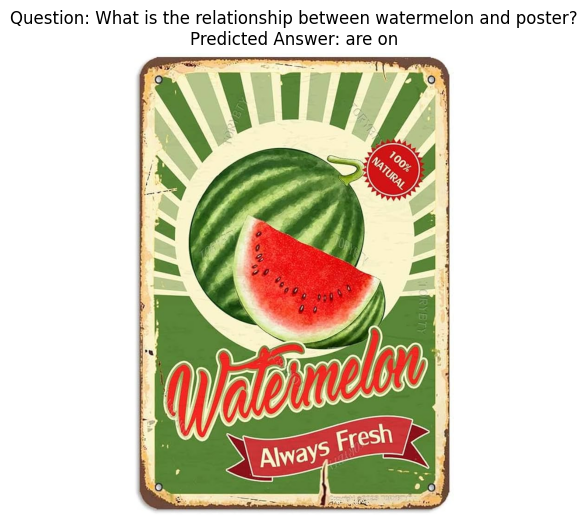

Question: What is the relationship between watermelon and poster?
Predicted Answer: are on


In [75]:
# Recognize objects in an uploaded image
uploaded_image_path = "/content/watermelon_poster (2).jpg"  # Replace with your image path
recognized_objects = recognize_objects_with_clip(uploaded_image_path, clip_base_model, processor, device, common_objects2)
print(f"Recognized Objects: {recognized_objects}")

# Generate a relationship question
question_template = "What is the relationship between {} and {}?"
if len(recognized_objects) >= 2:
    object1, object2 = recognized_objects[:2]
    question = question_template.format(object1, object2)
    print(f"Generated Question: {question}")
else:
    print("Not enough objects recognized to generate a relationship question.")

# Step 3: Predict Relationship using Fine-Tuned Model
if question:
    predicted_answer = predict_relationship(uploaded_image_path, question, clip_model_finetuned, processor, idx_to_answer, device)

    # Display Image and Results
    image = Image.open(uploaded_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Question: {question}\nPredicted Answer: {predicted_answer}")
    plt.show()

    print(f"Question: {question}")
    print(f"Predicted Answer: {predicted_answer}")
else:
    print("Failed to generate a valid question.")





Generated Question: What is the relationship between sofa and mattress?


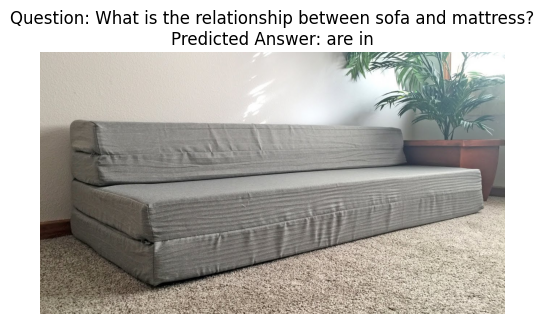

Question: What is the relationship between sofa and mattress?
Predicted Answer: are in


In [80]:

# Recognize objects in an uploaded image
uploaded_image_path = "/content/sofa_mattress.jpg"  # Replace with your image path
recognized_objects = recognize_objects_with_clip(uploaded_image_path, clip_base_model, processor, device, common_objects2)
print(f"Recognized Objects: {recognized_objects}")

# Generate a relationship question
question_template = "What is the relationship between {} and {}?"
if len(recognized_objects) >= 2:
    object1, object2 = recognized_objects[:2]
    question = question_template.format(object1, object2)
    print(f"Generated Question: {question}")
else:
    print("Not enough objects recognized to generate a relationship question.")

# Step 3: Predict Relationship using Fine-Tuned Model
if question:
    predicted_answer = predict_relationship(uploaded_image_path, question, clip_model_finetuned, processor, idx_to_answer, device)

    # Display Image and Results
    image = Image.open(uploaded_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title(f"Question: {question}\nPredicted Answer: {predicted_answer}")
    plt.show()

    print(f"Question: {question}")
    print(f"Predicted Answer: {predicted_answer}")
else:
    print("Failed to generate a valid question.")





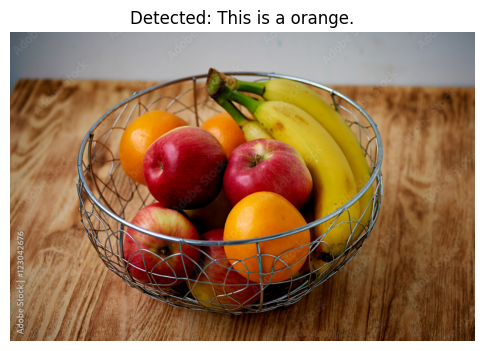

Recognized Objects: ['orange']
This is a orange.


In [83]:
def recognize_objects_with_clip(image_path, clip_model, processor, device, common_objects, batch_size=100):
    """
    Recognizes objects in an image using a large list of common objects.
    Args:
        image_path: Path to the image.
        clip_model: CLIP base model.
        processor: CLIP processor.
        device: CUDA or CPU.
        common_objects: Large list of objects to recognize.
        batch_size: Batch size for text processing.
    Returns:
        recognized_objects: List of recognized objects.
    """
    recognized_objects = []
    image = Image.open(image_path).convert("RGB").resize((224, 224))

    # Process common_objects in batches
    for i in range(0, len(common_objects), batch_size):
        batch = common_objects[i : i + batch_size]
        inputs = processor(
            text=batch, images=image, return_tensors="pt", padding=True
        ).to(device)

        with torch.no_grad():
            logits_per_image = clip_model(**inputs).logits_per_image  # [1, batch_size]
            probs = logits_per_image.softmax(dim=1)  # Apply softmax over batch

        # Get top-1 probabilities and their corresponding objects for the batch
        top_indices = probs[0].topk(1).indices  # Take the top index
        recognized_objects.extend([batch[idx] for idx in top_indices])

    # Return unique objects recognized
    return list(set(recognized_objects))


def predict_relationship_or_identify(image_path, question_template, clip_base_model, clip_finetuned_model, processor, idx_to_answer, device, common_objects):
    """
    Recognizes objects and predicts relationships or identifies objects if only one is found.
    Args:
        image_path: Path to the image.
        question_template: Template for relationship questions.
        clip_base_model: CLIP base model for object recognition.
        clip_finetuned_model: Fine-tuned CLIP model for relationship prediction.
        processor: CLIP processor.
        idx_to_answer: Mapping from answer indices to labels.
        device: CUDA or CPU.
        common_objects: List of common objects for recognition.
    Returns:
        Recognized objects, generated question, and predicted answer.
    """
    recognized_objects = recognize_objects_with_clip(image_path, clip_base_model, processor, device, common_objects)

    if len(recognized_objects) == 1:
        return recognized_objects, None, f"This is a {recognized_objects[0]}."
    elif len(recognized_objects) >= 2:
        object1, object2 = recognized_objects[:2]
        question = question_template.format(object1, object2)
        image = Image.open(image_path).convert("RGB")
        inputs = processor(text=question, images=image, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            logits = clip_finetuned_model(inputs["input_ids"], inputs["pixel_values"])
            predicted_idx = logits.argmax(dim=1).item()
            predicted_answer = idx_to_answer.get(predicted_idx, "unknown")

        return recognized_objects, question, predicted_answer
    else:
        return recognized_objects, None, "No recognizable objects detected."


# Example Usage
if __name__ == "__main__":
    # Define common objects
    common_objects = ["apple", "orange", "banana", "table", "chair", "car", "person", "dog", "cat", "book"]

    # Inputs
    uploaded_image_path = "/content/apples_orange.jpg"  # Replace with your image
    question_template = "What is the relationship between {} and {}?"

    # Run Prediction
    recognized_objects, question, result = predict_relationship_or_identify(
        uploaded_image_path, question_template, clip_base_model, clip_model_finetuned, processor, idx_to_answer, device, common_objects
    )

    # Display Image and Results
    image = Image.open(uploaded_image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    if question:
        plt.title(f"Question: {question}\nPredicted Answer: {result}")
    else:
        plt.title(f"Detected: {result}")
    plt.show()

    print(f"Recognized Objects: {recognized_objects}")
    if question:
        print(f"Question: {question}")
        print(f"Predicted Answer: {result}")
    else:
        print(result)
